In [1]:
!git clone https://github.com/JordanFoss/STAT3007_Project.git
%cd STAT3007_Project/

Cloning into 'STAT3007_Project'...
remote: Enumerating objects: 3982, done.
remote: Counting objects: 100% (260/260), done.
remote: Compressing objects: 100% (209/209), done.
remote: Total 3982 (delta 114), reused 168 (delta 49), pack-reused 3722
Receiving objects: 100% (3982/3982), 677.11 MiB | 18.16 MiB/s, done.
Resolving deltas: 100% (699/699), done.
Checking out files: 100% (2855/2855), done.
/content/STAT3007_Project


In [2]:
pip install colorednoise

  Created wheel for colorednoise: filename=colorednoise-1.1.1-cp37-none-any.whl size=3958 sha256=8e8d95479f94f3fd83fa0e15c20c1d8c90386b248463dd1badf837398da8dd4b
  Stored in directory: /root/.cache/pip/wheels/84/be/f3/3e7e1c80ebab3f6f0dbd3e34e787b902d2280d66706485fef4
Successfully built colorednoise


In [3]:
import librosa
from librosa import display
import colorednoise as cn
import torch
import numpy as np
from IPython.display import Audio
import glob
from pre_process import *
from data_loading import *
import os
import torch.optim as optim
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import ToTensor

import scipy
from torchsummary import summary

configure the device

In [4]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device == torch.device('cuda'))

True


load the spectrogram data, 40 snr

In [5]:
train_noisy_spectrogram = np.load('/content/drive/MyDrive/Colab_Notebooks/stat3007/Project/STAT3007_project/train_test_split_snr40/noisy_train_snr40.npy')
train_clean_spectrogram = np.load('/content/drive/MyDrive/Colab_Notebooks/stat3007/Project/STAT3007_project/train_test_split_snr40/clean_train_snr40.npy')
test_noisy_spectrogram = np.load('/content/drive/MyDrive/Colab_Notebooks/stat3007/Project/STAT3007_project/train_test_split_snr40/noisy_test_snr40.npy')
test_clean_spectrogram = np.load('/content/drive/MyDrive/Colab_Notebooks/stat3007/Project/STAT3007_project/train_test_split_snr40/clean_test_snr40.npy')

In [6]:
train_noisy_spectrogram = train_noisy_spectrogram.reshape(train_noisy_spectrogram.shape[0],1,train_noisy_spectrogram.shape[1],train_noisy_spectrogram.shape[2])
train_clean_spectrogram = train_clean_spectrogram.reshape(train_clean_spectrogram.shape[0],1,train_clean_spectrogram.shape[1],train_clean_spectrogram.shape[2])
test_noisy_spectrogram = test_noisy_spectrogram.reshape(test_noisy_spectrogram.shape[0],1,test_noisy_spectrogram.shape[1],test_noisy_spectrogram.shape[2])
test_clean_spectrogram = test_clean_spectrogram.reshape(test_clean_spectrogram.shape[0],1,test_clean_spectrogram.shape[1],test_clean_spectrogram.shape[2])


In [7]:
print(train_noisy_spectrogram.shape)
print(train_clean_spectrogram.shape)
print(test_noisy_spectrogram.shape)
print(test_clean_spectrogram.shape)

(6880, 1, 128, 63)
(6880, 1, 128, 63)
(3440, 1, 128, 63)
(3440, 1, 128, 63)


In [8]:
denoise_train = DatasetWrapper(torch.tensor(train_noisy_spectrogram), torch.tensor(train_clean_spectrogram))
denoise_test = DatasetWrapper(torch.tensor(test_noisy_spectrogram), torch.tensor(test_clean_spectrogram))

# Network Architecture

In [10]:
# Autoencoder with optimal hyper-parameters already put in
class Encoder(nn.Module):
  def __init__(self, filters = 8, kernal_size = (3,4)):
    super(Encoder, self).__init__()
    (K, S) = (5, 1)
    self.conv = nn.Sequential(nn.Conv2d(1, filters, kernel_size= kernal_size, stride = 1),
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size = 2),
                              nn.ReLU(),
                              nn.Conv2d(filters,filters,kernel_size= kernal_size, stride = 1),
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size = 2),
                              nn.Conv2d(filters,filters,kernel_size= kernal_size, stride = 1),
                              nn.ReLU()
                              )
    
  def forward(self, x):
    x = self.conv(x)
    return x


class Decoder(nn.Module):
  def __init__(self, filters = 8, kernal_size = (3,4), upsample_size1=(61,27), upsample_size2=(126,60)):
    super(Decoder, self).__init__()
    (K, S) = (2, 1)
    self.conv = nn.Sequential(nn.ConvTranspose2d(filters,filters, kernel_size = kernal_size),
                              nn.ReLU(),
                              nn.Upsample(size = upsample_size1),
                              nn.ConvTranspose2d(filters,filters, kernel_size = kernal_size),
                              nn.ReLU(),
                              nn.Upsample(size = upsample_size2),
                              nn.ConvTranspose2d(filters,1, kernel_size = kernal_size),
                              )
    
  def forward(self, x):
    x = self.conv(x)
    return x

class Autoencoder(nn.Module):
  def __init__(self, filters, kernal_size=(3,4), upsample_size1=(61,27), upsample_size2=(126,60)):
    super(Autoencoder,self).__init__()
    self.filters = filters
    self.kernal_size = kernal_size
    self.upsample_size1 = upsample_size1
    self.upsample_size2 = upsample_size2
    self.encoder = Encoder(filters, kernal_size)
    self.decoder = Decoder(filters, kernal_size, upsample_size1, upsample_size2)
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

In [11]:
test_encoder = Encoder()
test_decoder = Decoder()
# if cuda gps available: 
if device == torch.device('cuda'):
    test_ae = Autoencoder(8).cuda()
else:
    test_ae = Autoencoder(8)
summary(test_ae,(1,128,63))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 8, 126, 60]             104
              ReLU-2           [-1, 8, 126, 60]               0
         MaxPool2d-3            [-1, 8, 63, 30]               0
              ReLU-4            [-1, 8, 63, 30]               0
            Conv2d-5            [-1, 8, 61, 27]             776
              ReLU-6            [-1, 8, 61, 27]               0
         MaxPool2d-7            [-1, 8, 30, 13]               0
            Conv2d-8            [-1, 8, 28, 10]             776
              ReLU-9            [-1, 8, 28, 10]               0
          Encoder-10            [-1, 8, 28, 10]               0
  ConvTranspose2d-11            [-1, 8, 30, 13]             776
             ReLU-12            [-1, 8, 30, 13]               0
         Upsample-13            [-1, 8, 61, 27]               0
  ConvTranspose2d-14            [-1, 8,

In [12]:

def train_model(data, net, loss, nepoch ,lr = 0.01, batch_size = -1, use_cuda = False, print_output = True, test_data=None):
  
  # appropriate data type for CPU or GPU
  device = None
  if use_cuda and torch.cuda.is_available():
    # print()
    dtype = torch.cuda.FloatTensor
    device = torch.device("cuda")
    net = net.to(device)
  else:
    dtype = torch.FloatTensor

  optimizer = optim.Adam(net.parameters(), lr = lr)
  # print(type(data))
  data = data.change_type(dtype)
  test_data = test_data.change_type(dtype)

  # test data
  if test_data != None:
      X_test, y_test = test_data.get_data()
    #   X_test = X_test.to('cpu')
    #   y_test = y_test.to('cpu')
      # print(type(X_test))
      test_losses = []

  if batch_size == -1:
    data_loader = DataLoader(data,
                         batch_size = data.dataset__len__, shuffle = True)
  
  else:
    data_loader = DataLoader(data,
                             batch_size = batch_size, shuffle = True)

  train_losses = []

  for epoch in range(nepoch):
     batch_losses = []
     for X_batch, y_batch in data_loader:
      # y_batch = y_batch.reshape(y_batch.shape[0],1,y_batch.shape[1],y_batch.shape[2])
      if use_cuda and device != None:
        # net = net.to(device)
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

      optimizer.zero_grad()

      # since all our values are negative, we convert them to positive
      
      # print(next(net.parameters()).is_cuda)
      # print(id(net))
      pred = net(X_batch)

      Rn = loss(pred, y_batch)
      Rn.backward()
      optimizer.step()
      batch_losses.append(Rn.item())
     avg_loss = np.mean(np.array(batch_losses))
     train_losses.append(avg_loss)

     if test_data != None:
         # net_test = net.to(torch.device('cpu'))
         # net_test = net
         # print(id(net_test))
         test_pred = net(X_test)
         test_error = loss(test_pred, y_test)
         test_losses.append(test_error.item())

     if print_output:
      print('epoch:', epoch)
      print('loss:', avg_loss)
      print('------------')
     
    
  print('final loss:', Rn.item())

  if test_data != None:
    return net, train_losses, test_losses
  else:
    return net, train_losses, None

# Hyper-parameter turning

the number of filters

In [13]:
#@title Hyper-parameter turning - number of filters
loss = nn.MSELoss()
nepoch = 20
batch_size = 30
lr = 0.01
num_of_filter = {}
num_of_filter['nepoch'] = 20
num_of_filter['batch_size'] = 30
num_of_filter['lr'] = 0.01

filter_list = [8,14,16]
torch.manual_seed(69)

train_loss_log = []
test_loss_log = []


AE = Autoencoder(8)
_, train_losses, test_losses = train_model(denoise_train, AE, loss, nepoch=20, 
                                            lr=0.01, batch_size=30, use_cuda=False,
                                            print_output=False, test_data=denoise_test)
num_of_filter[8] = (train_losses, test_losses)

<class 'data_loading.DatasetWrapper'>
<class 'torch.Tensor'>


KeyboardInterrupt: ignored

In [15]:
loss = nn.MSELoss()
nepoch = 20
batch_size = 30
lr = 0.01
kernal_sizes = {}
kernal_sizes['nepoch'] = 20
kernal_sizes['batch_size'] = 30
kernal_sizes['lr'] = 0.01
kernal_sizes['num_of_filter'] = 8
kernal_size_list = [[(1,2),(64,30),(128,62)], [(1,3),(64,28),(128,61)], [(1,4),(64,27),(128,60)], 
                    [(2,1),(62,31),(127,63)], [(2,2),(62,30),(127,62)], [(2,3),(62,28),(127,61)], [(2,4),(62,27),(127,60)],
                    [(3,1),(61,31),(126,63)], [(3,2),(61,30),(126,62)], [(3,3),(61,28),(126,61)], [(3,4),(61,27),(126,60)],
                    [(4,1),(59,31),(125,63)], [(4,2),(59,30),(125,62)], [(4,3),(59,28),(125,61)], [(4,4),(59,27),(125,60)]]

torch.manual_seed(69)
for kernal_size in kernal_size_list:
    AE = Autoencoder(8, kernal_size[0], kernal_size[1], kernal_size[2])
    _, train_loss_log, test_loss_log = train_model(denoise_train,AE, loss, nepoch = nepoch,lr = 0.01, batch_size = batch_size, use_cuda = True,print_output = False)
    kernal_sizes[kernal_size[0]] = (train_loss_log, test_loss_log)


<class 'data_loading.DatasetWrapper'>
final loss: 100.69392395019531
<class 'data_loading.DatasetWrapper'>
final loss: 156.2526397705078
<class 'data_loading.DatasetWrapper'>
final loss: 112.13198852539062
<class 'data_loading.DatasetWrapper'>
final loss: 163.92572021484375
<class 'data_loading.DatasetWrapper'>
final loss: 97.91481018066406
<class 'data_loading.DatasetWrapper'>
final loss: 107.20813751220703
<class 'data_loading.DatasetWrapper'>
final loss: 107.58753967285156
<class 'data_loading.DatasetWrapper'>
final loss: 138.86216735839844
<class 'data_loading.DatasetWrapper'>
final loss: 103.71590423583984
<class 'data_loading.DatasetWrapper'>
final loss: 114.16757202148438
<class 'data_loading.DatasetWrapper'>
final loss: 121.14793395996094
<class 'data_loading.DatasetWrapper'>
final loss: 166.98779296875
<class 'data_loading.DatasetWrapper'>
final loss: 112.71426391601562
<class 'data_loading.DatasetWrapper'>
final loss: 119.54524993896484
<class 'data_loading.DatasetWrapper'>
f

In [17]:
kernal_size_train_loss = []
for kernal_size in kernal_size_list:
    train_loss_log = kernal_sizes[kernal_size[0]][0]
    kernal_size_train_loss.append(train_loss_log[-1].item())

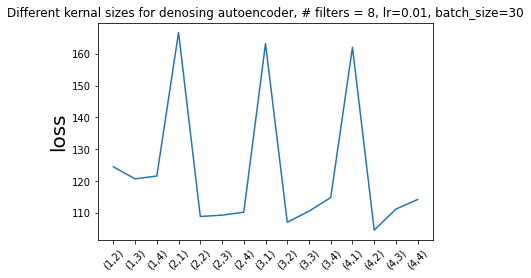

In [19]:
fig, ax = plt.subplots()
ax.plot(np.arange(1,16), kernal_size_train_loss)
ax.set_xticks(np.arange(1,16))
ax.set_xticklabels(['(1,2)','(1,3)','(1,4)','(2,1)','(2,2)','(2,3)','(2,4)','(3,1)',
                    '(3,2)','(3,3)','(3,4)','(4,1)','(4,2)','(4,3)','(4,4)'])
plt.xticks(rotation = 45)
plt.ylabel('loss', size=20)
plt.title('Different kernal sizes for denosing autoencoder, # filters = 8, lr=0.01, batch_size=30')
plt.show()

In [15]:
loss = nn.MSELoss()
AE2 = Autoencoder(8, (4,2), (59,30),(125,62))
net, train_loss_log, test_loss_log = train_model(denoise_train,AE2, loss, nepoch = 20,lr = 0.01, batch_size = 30, use_cuda = True,print_output = True, test_data=denoise_test)


<class 'data_loading.DatasetWrapper'>
epoch: 0
loss: 155.93165376275408
------------
epoch: 1
loss: 122.7345499695584
------------
epoch: 2
loss: 117.02884310014021
------------
epoch: 3
loss: 115.01793838437662
------------
epoch: 4
loss: 113.4583017499615
------------
epoch: 5
loss: 111.83734368288665
------------
epoch: 6
loss: 111.54444305926438
------------
epoch: 7
loss: 111.69103434075953
------------
epoch: 8
loss: 109.79725729281476
------------
epoch: 9
loss: 109.73786109512773
------------
epoch: 10
loss: 109.54084739843344
------------
epoch: 11
loss: 108.5152203571747
------------
epoch: 12
loss: 108.6055012936414
------------
epoch: 13
loss: 108.23187724386509
------------
epoch: 14
loss: 107.92266279038552
------------
epoch: 15
loss: 107.37544832981473
------------
epoch: 16
loss: 108.16399215761557
------------
epoch: 17
loss: 107.0480384668374
------------
epoch: 18
loss: 107.45446593731765
------------
epoch: 19
loss: 106.6598123574158
------------
final loss: 89.985

In [18]:
len(test_loss_log)

20

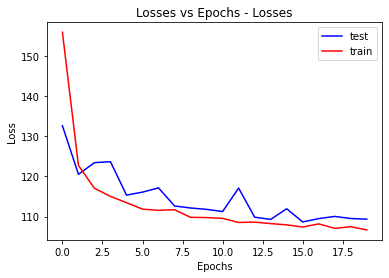

In [21]:
plt.plot(np.arange(len(test_loss_log)), test_loss_log, color='blue', label='test')
plt.plot(np.arange(len(train_loss_log)), train_loss_log, color='red', label='train')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Losses vs Epochs - Losses')
plt.show()

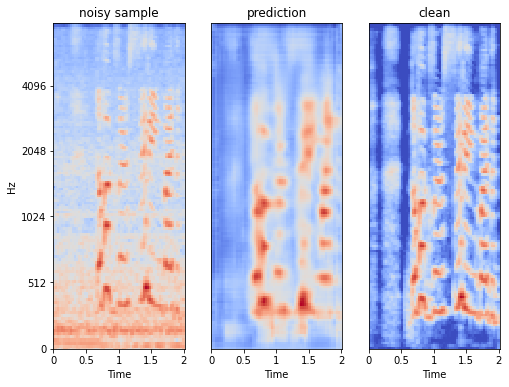

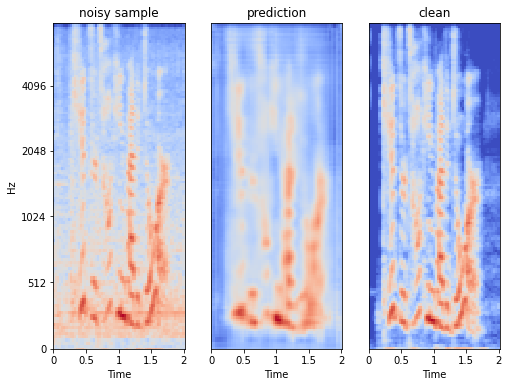

In [28]:
X_test, y_test = denoise_test.get_data()
X_test = X_test.type(torch.FloatTensor).to(torch.device('cpu'))
net = net.to(torch.device('cpu'))
y_pred = net(X_test)


for i in range(2):

    plt.figure(figsize = (8,6))
    plt.subplot2grid((1,3),(0,0))
    librosa.display.specshow(X_test[i,0].detach().numpy(), y_axis='mel', fmax=8000, x_axis='time', sr =16000);
    plt.title('noisy sample')

    plt.subplot2grid((1,3),(0,1))
    librosa.display.specshow(y_pred[i,0].detach().numpy(), fmax=8000, x_axis='time', sr =16000);
    plt.title('prediction')


    ax = plt.subplot2grid((1,3),(0,2))
    librosa.display.specshow(y_test[i,0].detach().numpy(), fmax=8000, x_axis='time', sr =16000);
    plt.title('clean')
    plt.show()

In [26]:
y_test.shape

torch.Size([3097, 1, 128, 63])

In [ ]:
loss = nn.MSELoss()
AE3 = Autoencoder(8, (4,2), (59,30),(125,62))
net, train_loss_log, test_loss_log = train_model(denoise_train,AE3, loss, nepoch = 50,lr = 0.01, batch_size = 30, use_cuda = True,print_output = True, test_data=denoise_test)


<class 'data_loading.DatasetWrapper'>
epoch: 0
loss: 153.986762430658
------------
epoch: 1
loss: 125.1937445486235
------------
epoch: 2
loss: 118.74798292737779
------------
epoch: 3
loss: 116.4273209947768
------------
epoch: 4
loss: 113.90429127166874
------------
epoch: 5
loss: 112.25061047819146
------------
epoch: 6
loss: 112.6096842279078
------------
epoch: 7
loss: 110.25876022275553
------------
epoch: 8
loss: 110.49200784517026
------------
epoch: 9
loss: 110.66269025367325
------------
epoch: 10
loss: 109.11504826209357
------------
epoch: 11
loss: 108.45274330867277
------------
epoch: 12
loss: 109.29983634473872
------------
epoch: 13
loss: 108.0200179800453
------------
epoch: 14
loss: 108.12129040476692
------------
epoch: 15
loss: 107.63957945637684
------------
epoch: 16
loss: 107.45748534143219
------------
epoch: 17
loss: 107.01524498650642
------------
epoch: 18
loss: 107.93046519172637
------------
epoch: 19
loss: 106.77187654487325
------------
epoch: 20
loss: 10

In [ ]:
X_test, y_test = data_test.dataset.get_data()
X_test = X_test.type(torch.FloatTensor).to(torch.device('cpu'))
trained_net = trained_net.to(torch.device('cpu'))
y_pred = trained_net(X_test)

for i in range(10):
    plt.figure(figsize = (8,8))
    plt.subplot2grid((1,3),(0,0))
    librosa.display.specshow(X_test[i,0].detach().numpy(), y_axis='mel', fmax=8000, x_axis='time', sr =16000);
    plt.title('noisy sample')

    plt.subplot2grid((1,3),(0,1))
    librosa.display.specshow(y_pred[i,0].detach().numpy(), fmax=8000, x_axis='time', sr =16000);
    plt.title('prediction')


    ax = plt.subplot2grid((1,3),(0,2))
    librosa.display.specshow(y_test[i].detach().numpy(), fmax=8000, x_axis='time', sr =16000);
    plt.title('clean')
    plt.show()

In [17]:
type(denoise_train)

data_loading.DatasetWrapper

In [8]:
# spectro_data = DatasetWrapper(X,y)
# train_size = int(X.shape[0] * 0.7)
# test_size = X.shape[0] - train_size

loss = nn.MSELoss()

# data_test, data_train = random_split(spectro_data,[test_size,train_size], generator = torch.Generator().manual_seed(10))
nepoch = 500
batch_size = 30

torch.manual_seed(69)
AE = Autoencoder(8)

trained_net = train_model(denoise_train, AE, loss, nepoch = nepoch,lr = 0.01, batch_size = batch_size, use_cuda = True,print_output = True)

NameError: ignored

<class '__main__.Autoencoder'>


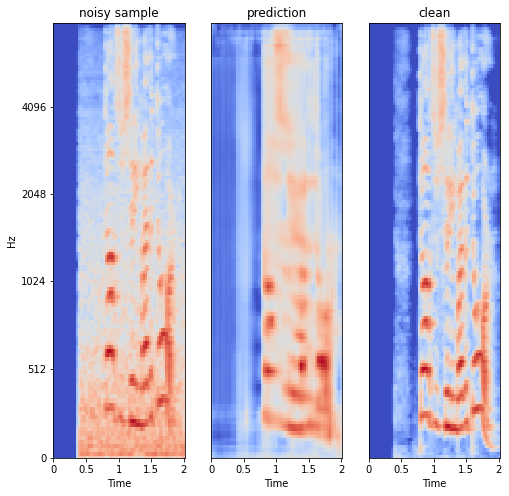

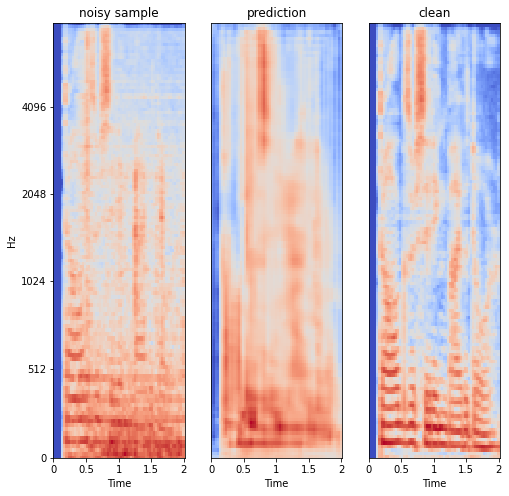

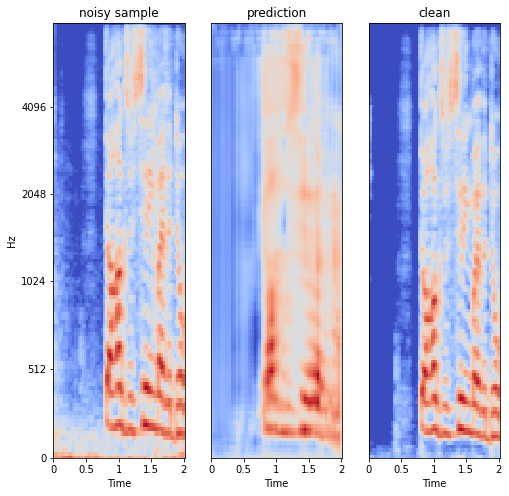

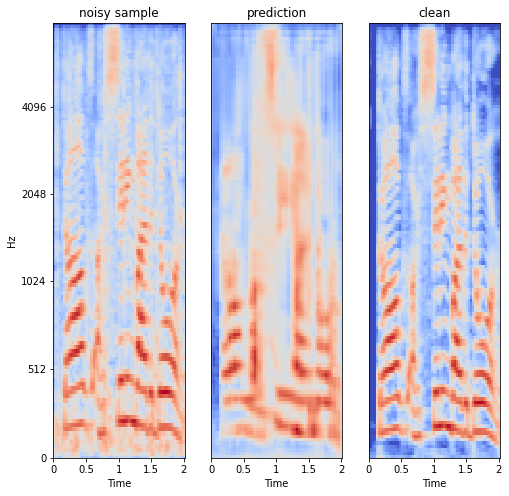

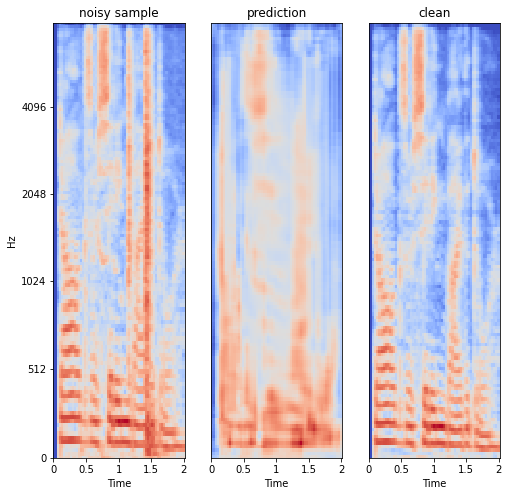

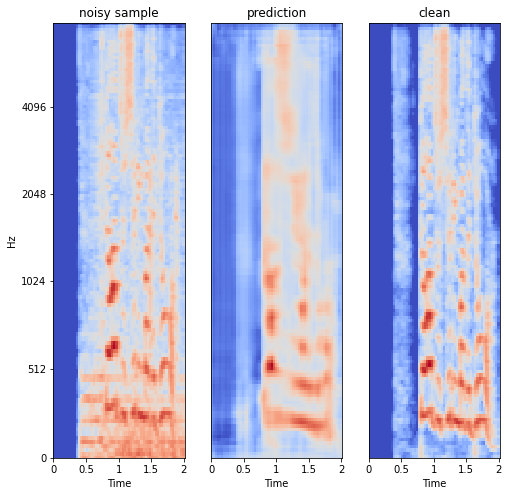

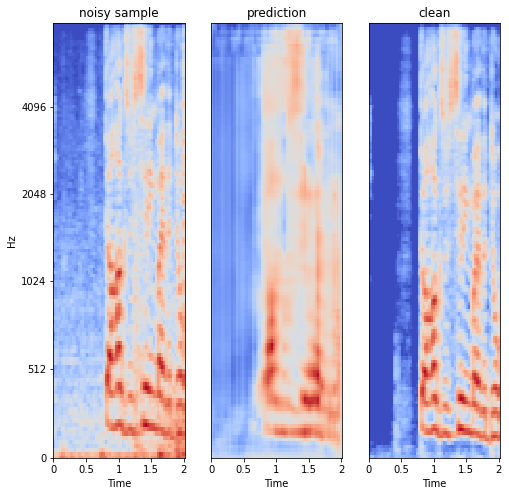

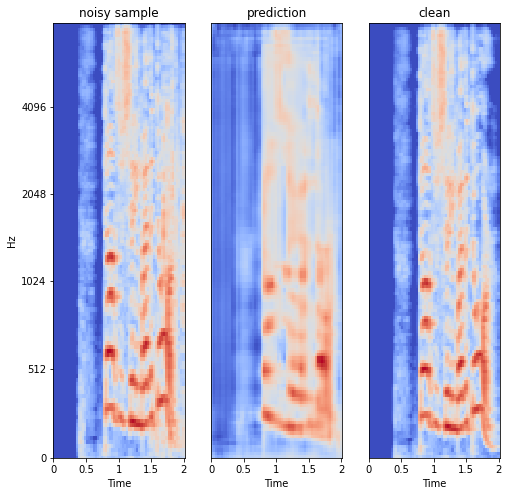

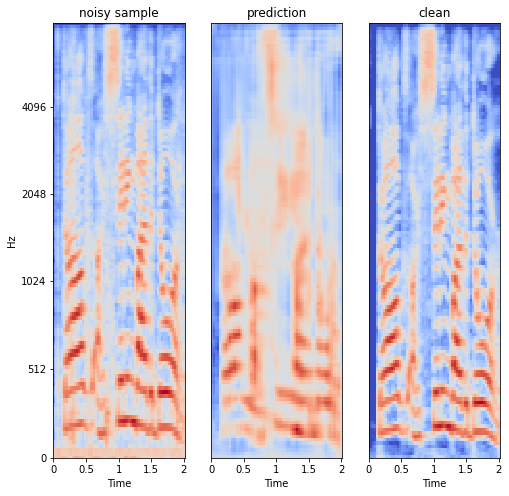

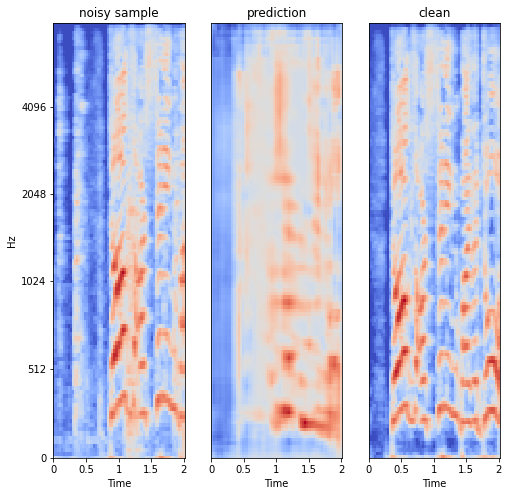

In [38]:
X_test, y_test = data_test.dataset.get_data()
X_test = X_test.type(torch.FloatTensor).to(torch.device('cpu'))
if (device == torch.device('cuda')):
    trained_net = trained_net.to(torch.device('cpu'))
print(type(trained_net))
y_pred = trained_net(X_test)

for i in range(10):
    plt.figure(figsize = (8,8))
    plt.subplot2grid((1,3),(0,0))
    librosa.display.specshow(X_test[i,0].detach().numpy(), y_axis='mel', fmax=8000, x_axis='time', sr =16000);
    plt.title('noisy sample')

    plt.subplot2grid((1,3),(0,1))
    librosa.display.specshow(y_pred[i,0].detach().numpy(), fmax=8000, x_axis='time', sr =16000);
    plt.title('prediction')


    ax = plt.subplot2grid((1,3),(0,2))
    librosa.display.specshow(y_test[i].detach().numpy(), fmax=8000, x_axis='time', sr =16000);
    plt.title('clean')
    plt.show()

# I will train with all the noisy data on the drive, 50 epochs, with another optimal hyper-parameters

In [13]:
loss = nn.MSELoss()
AE4 = Autoencoder(8, (4,2), (59,30),(125,62))
net, train_loss_log, test_loss_log = train_model(denoise_train, AE4, loss, nepoch = 50,lr = 0.01, batch_size = 30, use_cuda = True,print_output = True, test_data=denoise_test)

epoch: 0
loss: 191.9180710502293
------------
epoch: 1
loss: 116.57965688290804
------------
epoch: 2
loss: 108.04381511522377
------------
epoch: 3
loss: 104.28294117139734
------------
epoch: 4
loss: 102.9606090379798
------------
epoch: 5
loss: 101.20085439267366
------------
epoch: 6
loss: 99.9124055945355
------------
epoch: 7
loss: 99.29321935902472
------------
epoch: 8
loss: 98.68547419672427
------------
epoch: 9
loss: 97.52422538425611
------------
epoch: 10
loss: 96.6481566387674
------------
epoch: 11
loss: 96.88393531467604
------------
epoch: 12
loss: 95.53708021744438
------------
epoch: 13
loss: 95.20906790028448
------------
epoch: 14
loss: 94.1542772376019
------------
epoch: 15
loss: 93.62610321044922
------------
epoch: 16
loss: 94.0361338408097
------------
epoch: 17
loss: 93.57994149249532
------------
epoch: 18
loss: 93.02386710125467
------------
epoch: 19
loss: 93.2870120504628
------------
epoch: 20
loss: 93.32028735616933
------------
epoch: 21
loss: 92.51350

# Save state_dict()

In [16]:
state_save_path = '/content/drive/MyDrive/Colab_Notebooks/stat3007/Project/STAT3007_project/denoised_saved_model_parameters'
torch.save(net.state_dict(), state_save_path)

In [17]:
model = Autoencoder(8, (4,2), (59,30),(125,62))
model.load_state_dict(torch.load(state_save_path))

<All keys matched successfully>

<class '__main__.Autoencoder'>


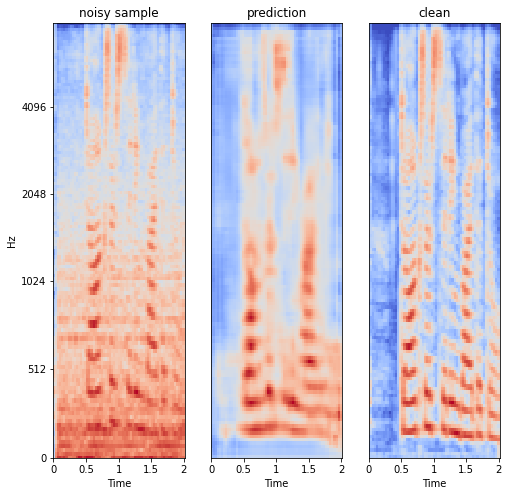

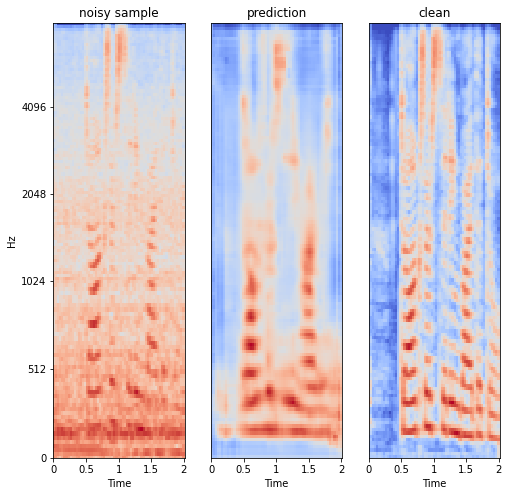

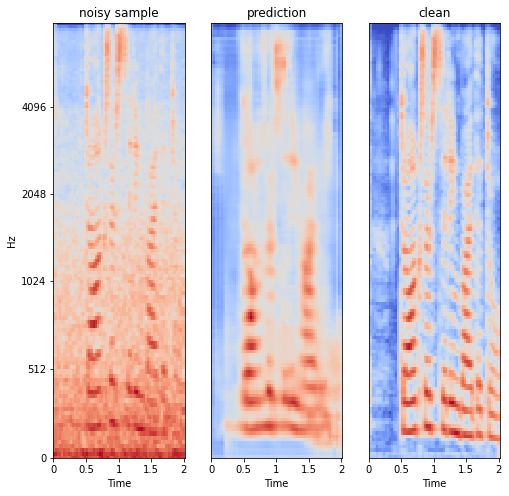

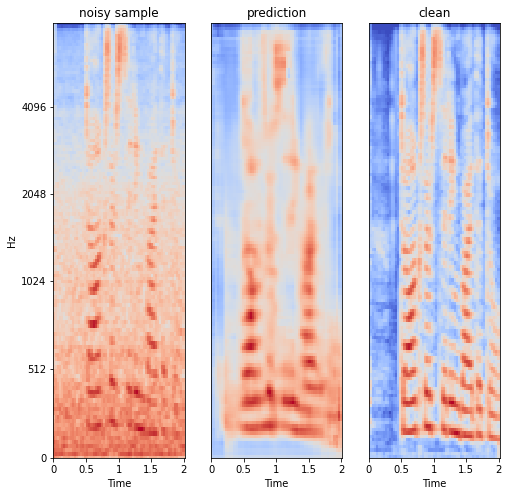

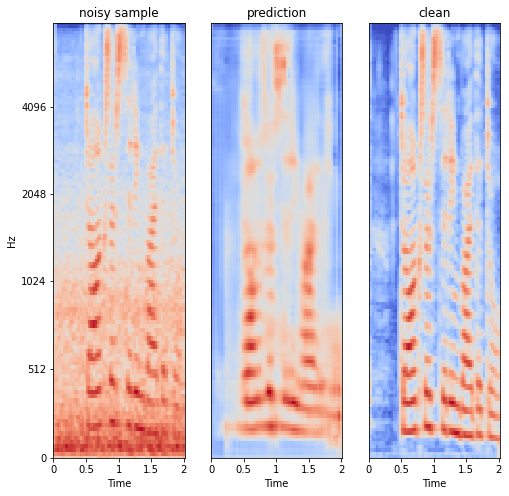

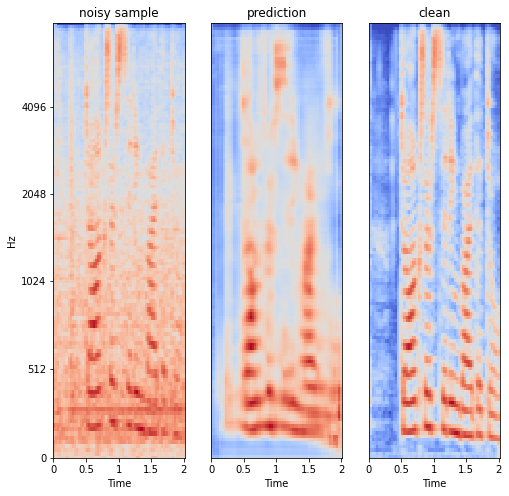

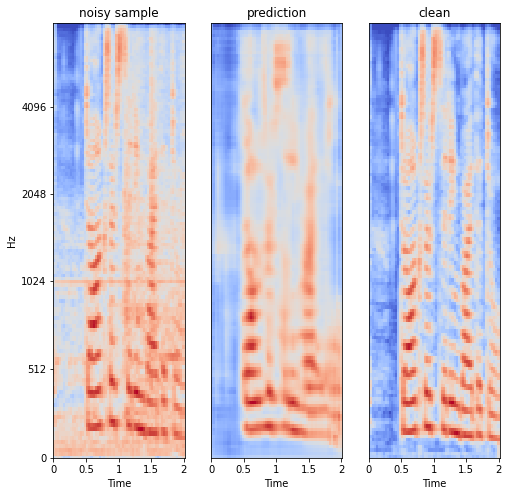

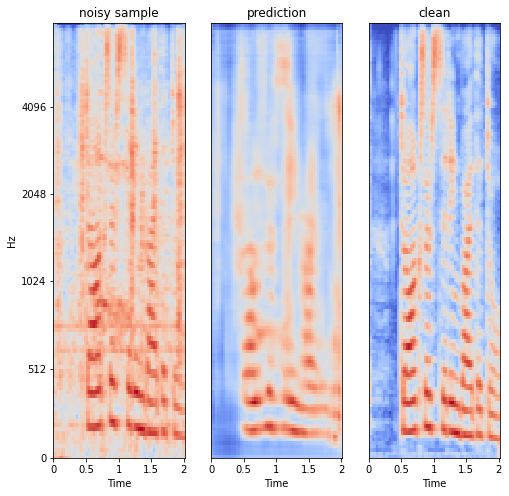

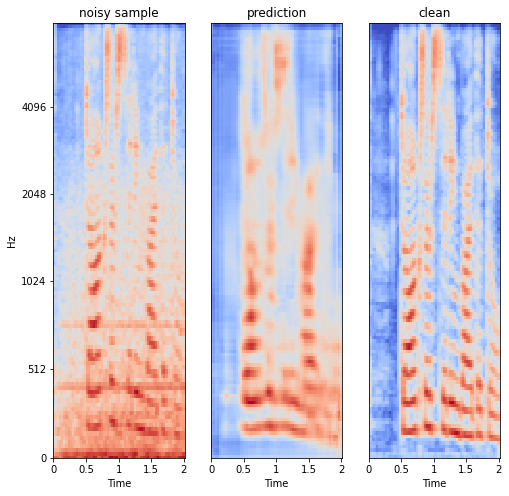

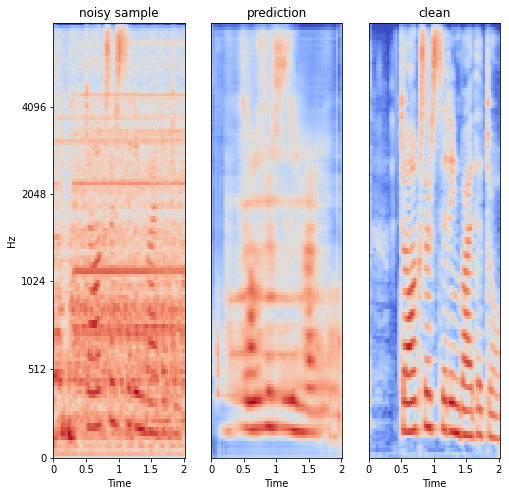

In [21]:
X_test, y_test = denoise_test.get_data()
X_test = X_test.type(torch.FloatTensor).to(torch.device('cpu'))
if (device == torch.device('cuda')):
    model = model.to(torch.device('cpu'))
print(type(model))
y_pred = model(X_test)

for i in range(10):
    plt.figure(figsize = (8,8))
    plt.subplot2grid((1,3),(0,0))
    librosa.display.specshow(X_test[i,0].detach().numpy(), y_axis='mel', fmax=8000, x_axis='time', sr =16000);
    plt.title('noisy sample')

    plt.subplot2grid((1,3),(0,1))
    librosa.display.specshow(y_pred[i,0].detach().numpy(), fmax=8000, x_axis='time', sr =16000);
    plt.title('prediction')


    ax = plt.subplot2grid((1,3),(0,2))
    librosa.display.specshow(y_test[i,0].detach().numpy(), fmax=8000, x_axis='time', sr =16000);
    plt.title('clean')
    plt.show()

# Save model

In [14]:
state_save_path = '/content/drive/MyDrive/Colab_Notebooks/stat3007/Project/STAT3007_project/denoised_saved_model'

In [18]:
torch.save(net, state_save_path)

In [16]:
the_model = torch.load(state_save_path)


<class '__main__.Autoencoder'>


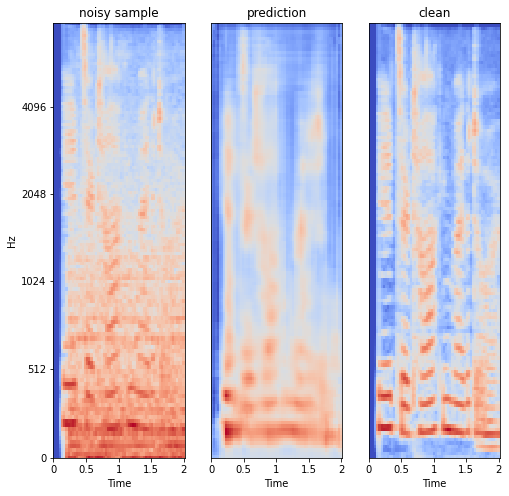

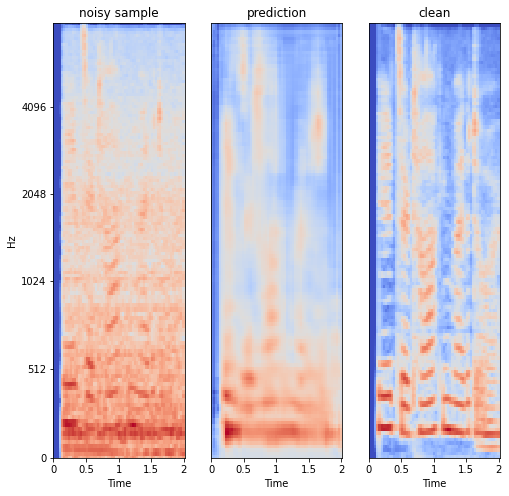

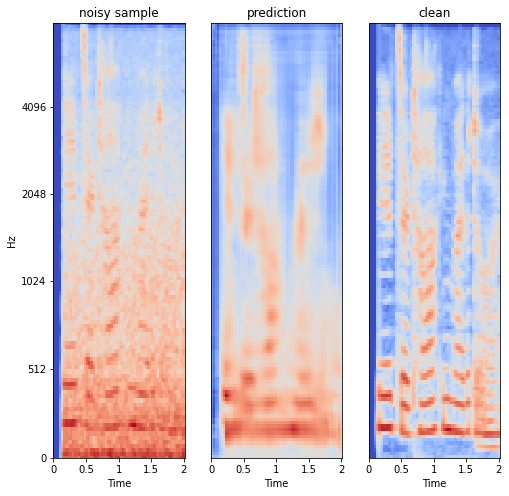

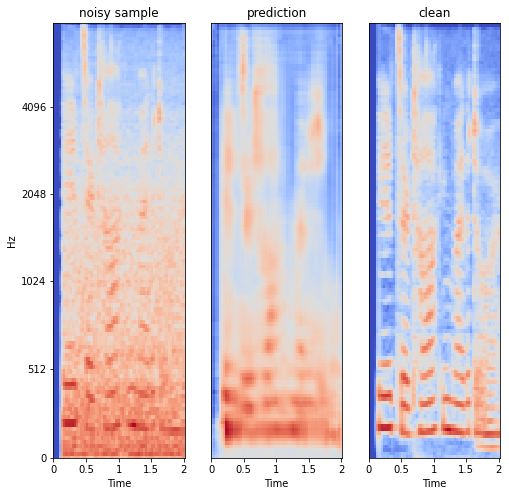

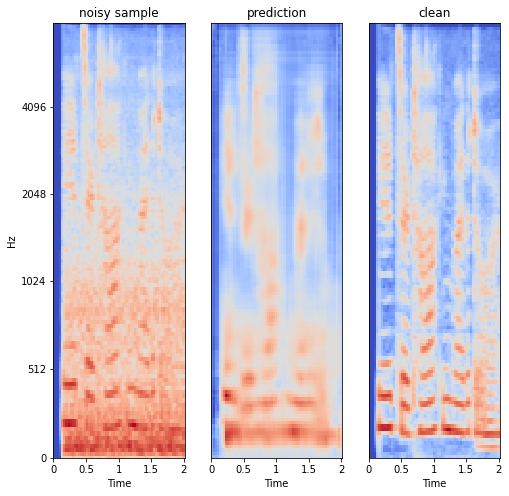

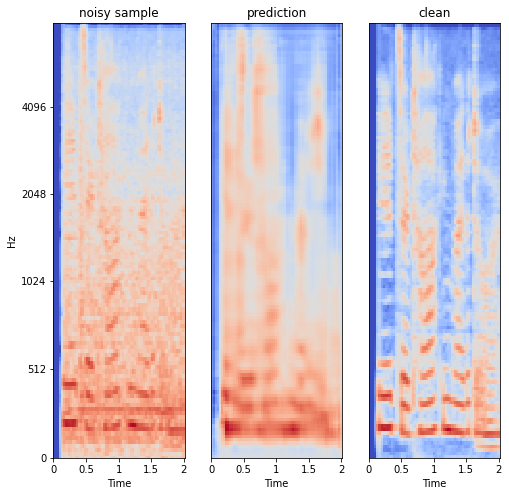

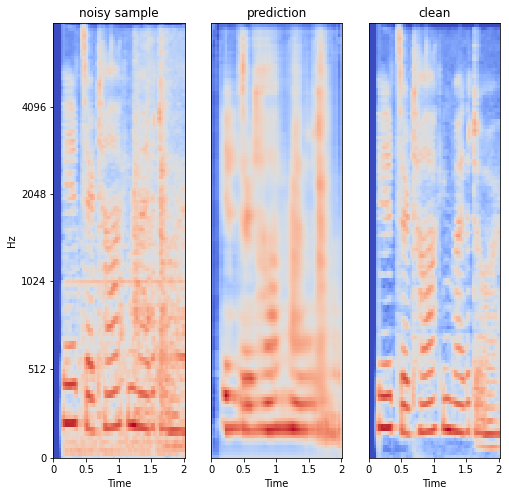

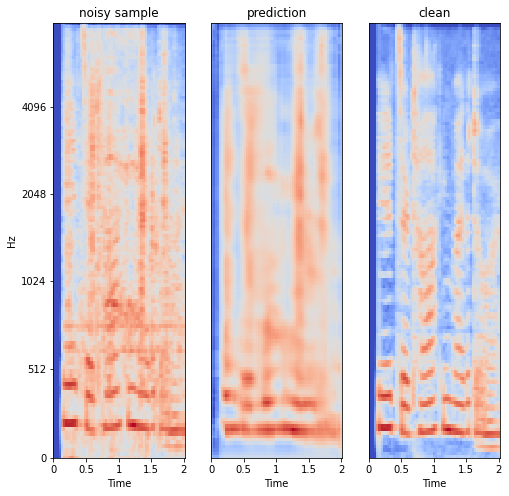

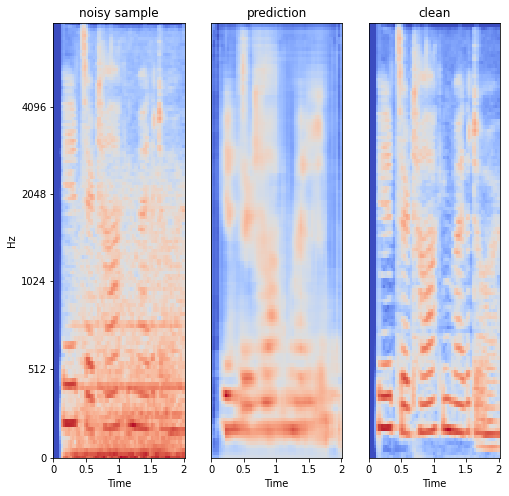

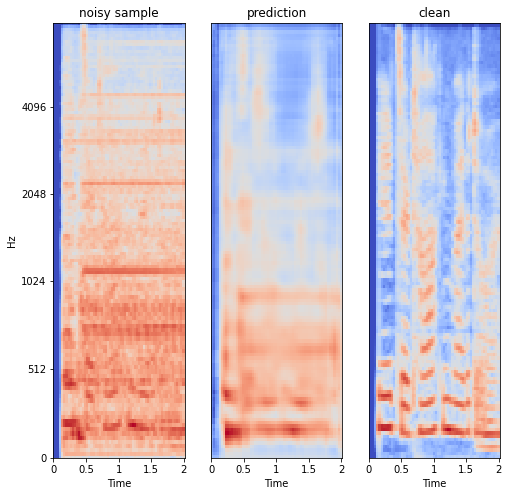

In [17]:
X_test, y_test = denoise_test.get_data()
X_test = X_test.type(torch.FloatTensor).to(torch.device('cpu'))
if (device == torch.device('cuda')):
    the_model = the_model.to(torch.device('cpu'))
print(type(the_model))
y_pred = the_model(X_test)

for i in range(10):
    plt.figure(figsize = (8,8))
    plt.subplot2grid((1,3),(0,0))
    librosa.display.specshow(X_test[i,0].detach().numpy(), y_axis='mel', fmax=8000, x_axis='time', sr =16000);
    plt.title('noisy sample')

    plt.subplot2grid((1,3),(0,1))
    librosa.display.specshow(y_pred[i,0].detach().numpy(), fmax=8000, x_axis='time', sr =16000);
    plt.title('prediction')


    ax = plt.subplot2grid((1,3),(0,2))
    librosa.display.specshow(y_test[i,0].detach().numpy(), fmax=8000, x_axis='time', sr =16000);
    plt.title('clean')
    plt.show()